### IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install -q kaggle


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\vidya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
#!/bin/bash
!kaggle datasets download marcopinamonti/alzheimer-mri-4-classes-dataset

Dataset URL: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset
License(s): unknown
alzheimer-mri-4-classes-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -q alzheimer-mri-4-classes-dataset.zip -d /content/dataset

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Reading data

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 0

tf.random.set_seed(SEED)

directory = 'Alzheimer_MRI_4_classes_dataset'

train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Splitting validation and testing datasets

In [6]:
validation_batches = len(full_validation_dataset)
print(f'Total number of full_validation_dataset batches : {validation_batches}')

validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


In [7]:
class_names = train_dataset.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

## Exploring some samples

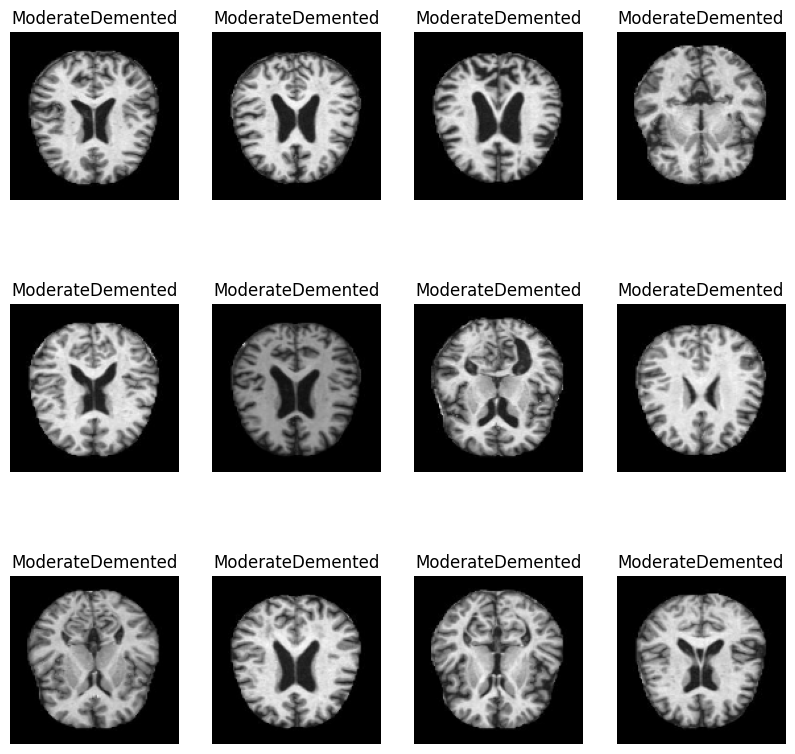

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

In [9]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [10]:
def data_augmentar():
    """This function applies two data augmentation techniques.
        First, augmentation with RandomRotation.
        Second, augmentation with RandomZoom
    """

    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))

    return data_augmentation

In [12]:
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

# Define the augmentation function
def data_augmentar():
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15), name='random_rotation'))
    data_augmentation.add(RandomZoom(height_factor=(-0.3, -0.1), name='random_zoom'))
    return data_augmentation

# Initialize the data augmentation pipeline
data_augmentation = data_augmentar()

# Verifying using the configuration
rotation_config = data_augmentation.layers[0].get_config()
zoom_config = data_augmentation.layers[1].get_config()

# Assertions
assert data_augmentation.layers[0].name.startswith('random_rotation')
assert rotation_config['factor'] == (-0.15, 0.15), f"Unexpected factor: {rotation_config['factor']}"
assert data_augmentation.layers[1].name.startswith('random_zoom')
assert zoom_config['height_factor'] == (-0.3, -0.1), f"Unexpected height_factor: {zoom_config['height_factor']}"

print("All assertions passed!")


All assertions passed!


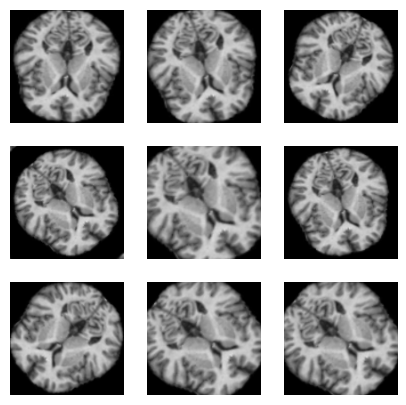

In [13]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

## Solving Imbalanced Data Problem

In [14]:
## Calculate number of samples in each class.

class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(directory+'/'+folder))

class_counts

{'MildDemented': 896,
 'ModerateDemented': 64,
 'NonDemented': 3200,
 'VeryMildDemented': 2240}

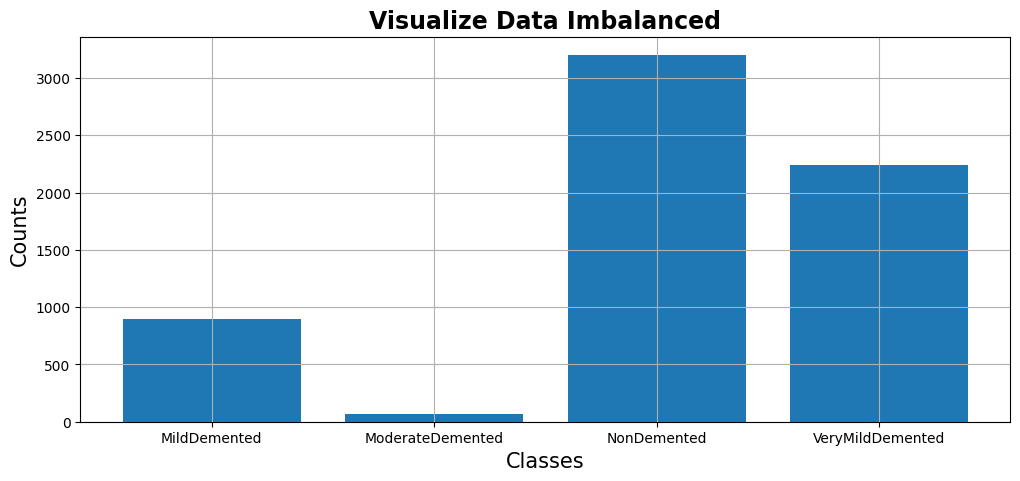

In [15]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [16]:
## Calculate class weights.

total = sum(class_counts.values())
number_of_classes = len(class_counts)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "MildDemented" : 1.79
Weight for class "ModerateDemented" : 25.0
Weight for class "NonDemented" : 0.5
Weight for class "VeryMildDemented" : 0.71


### EfficientNetB0

In [17]:
preprocess_input = applications.efficientnet.preprocess_input

In [18]:
model = applications.EfficientNetB0(include_top=False)
len(model.layers)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


238

In [19]:
from tensorflow.keras.layers import RandomRotation, RandomZoom, Input
from tensorflow.keras.models import Sequential

def data_augmentar(input_shape=(128, 128, 3)):
    """This function applies two data augmentation techniques:
    1. Augmentation with RandomRotation.
    2. Augmentation with RandomZoom.

    Arguments:
        input_shape -> Shape of the input tensor (height, width, channels).

    Returns:
        data_augmentation -> Sequential model for data augmentation.
    """
    data_augmentation = Sequential([
        Input(shape=input_shape),
        RandomRotation(factor=(-0.15, 0.15), name='random_rotation'),
        RandomZoom(height_factor=(-0.3, -0.1), name='random_zoom'),
    ])
    return data_augmentation


In [20]:
def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=None):
    """Creates a classifier for Alzheimer disease MRI images.

    Arguments:
        image_shape -> The size of the image in the form (height, width).
        data_augmentation -> The data augmentation object to apply on training data.

    Returns:
        model -> The created classifier.
    """
    IMG_SHAPE = image_shape + (3,)  # Assuming image_shape is (128, 128)
    base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

    base_model.trainable = True
    for layer in base_model.layers[:218]:
        layer.trainable = False

    inputs = Input(shape=IMG_SHAPE)
    if data_augmentation:
        x = data_augmentation(inputs)
    else:
        x = inputs

    x = preprocess_input(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=4, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model


In [21]:
data_augmentation = data_augmentar(IMG_SIZE + (3,))
alzheimer_model = alzheimer_classifier(IMG_SIZE, data_augmentation)

alzheimer_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

alzheimer_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 1,356,084 (5.17 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [22]:
tf.keras.utils.plot_model(alzheimer_model, show_shapes=True, dpi=150)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
lr = 0.001
alzheimer_model.compile(loss=CategoricalCrossentropy(),
                        optimizer=Adam(learning_rate=lr),
                        metrics=['accuracy',
                                tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),])

In [24]:

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

callback_list = [earlystopping]

### MODEL TRAINING

In [25]:
history = alzheimer_model.fit(train_dataset,
                              validation_data = validation_dataset,
                              epochs = 80,
                              class_weight=class_weights, callbacks = callback_list)

Epoch 1/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 311ms/step - accuracy: 0.3826 - auc_1: 0.6763 - loss: 1.4061 - precision_1: 0.4496 - recall_1: 0.2362 - val_accuracy: 0.5188 - val_auc_1: 0.8021 - val_loss: 1.0230 - val_precision_1: 0.5593 - val_recall_1: 0.3391
Epoch 2/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.4635 - auc_1: 0.7637 - loss: 1.0432 - precision_1: 0.5633 - recall_1: 0.2979 - val_accuracy: 0.5562 - val_auc_1: 0.8312 - val_loss: 0.9377 - val_precision_1: 0.6900 - val_recall_1: 0.3547
Epoch 3/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 275ms/step - accuracy: 0.5199 - auc_1: 0.8010 - loss: 0.8868 - precision_1: 0.6145 - recall_1: 0.3728 - val_accuracy: 0.5391 - val_auc_1: 0.8428 - val_loss: 0.9145 - val_precision_1: 0.5958 - val_recall_1: 0.4469
Epoch 4/80
160/160 ━━━━━━━━━━━━━━━━━━━━ 44s 275ms/step - accuracy: 0.5303 - auc_1: 0.8125 - loss: 0.9607 - precision_1: 0.6214 - recall_1: 0.3973 - val_accuracy: 0.5953 - val_auc_1: 0.8587 - val_loss: 0.8677 - val_precision_1: 0.

In [26]:
alzheimer_model.save('efficientnetmodel.keras')

### PLOTTING RESULTS:

In [27]:
result = alzheimer_model.evaluate(test_dataset)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Test Loss = {train_loss}')
print(f'Test Accuracy = {train_accuracy}')
print(f'Test AUC = {train_AUC}')
print(f'Test Precision = {train_pre}')
print(f'Test Recall = {train_rec}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7039 - auc_1: 0.9179 - loss: 0.8886 - precision_1: 0.7065 - recall_1: 0.6955
Test Loss = 0.8772515058517456
Test Accuracy = 0.7109375
Test AUC = 0.917966365814209
Test Precision = 0.7191011309623718
Test Recall = 0.699999988079071


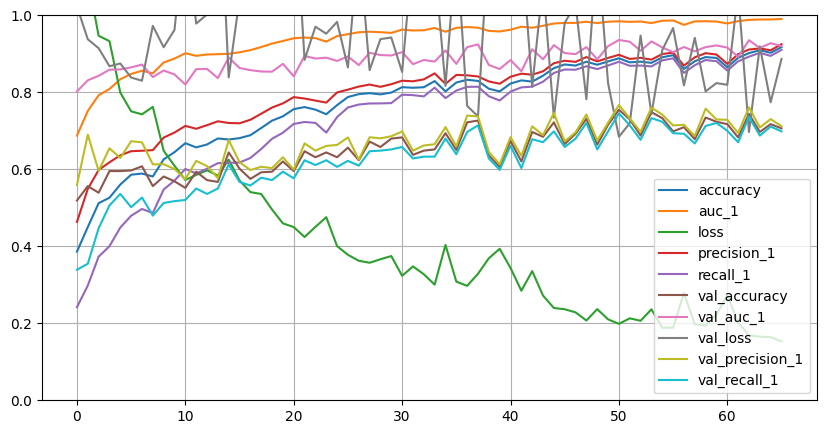

In [28]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

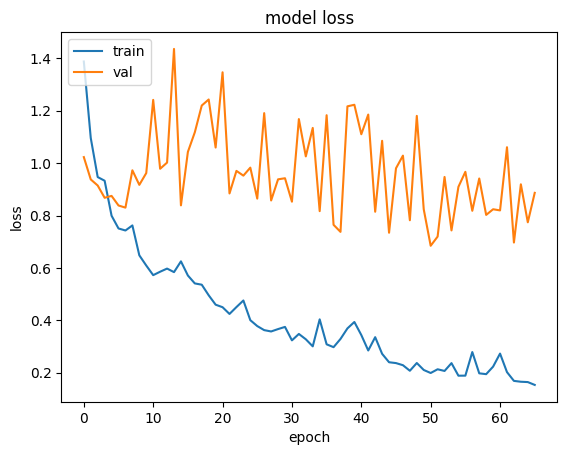

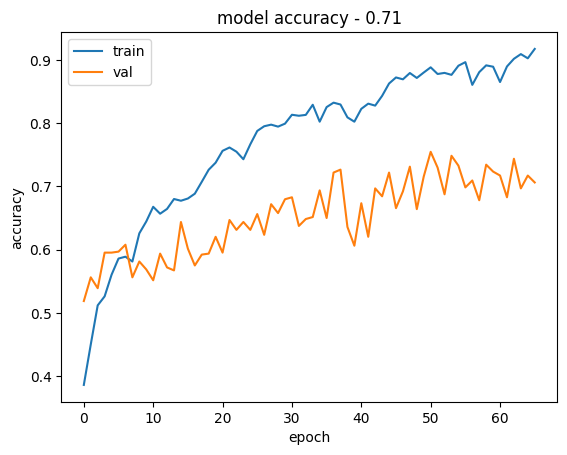

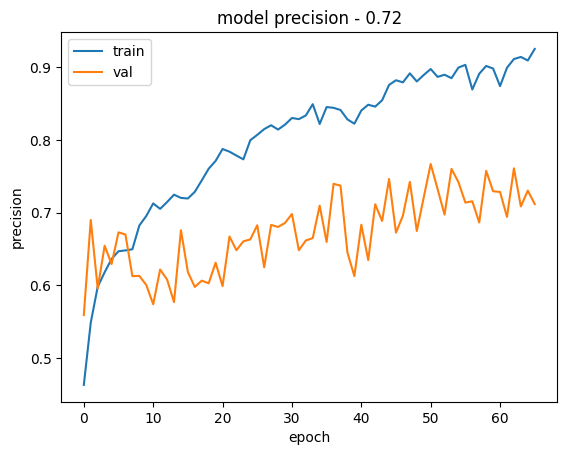

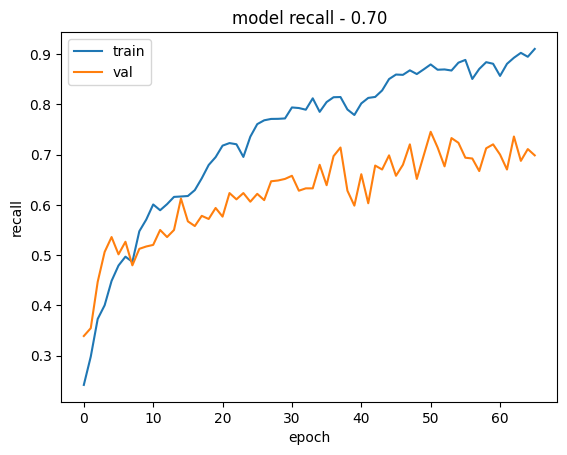

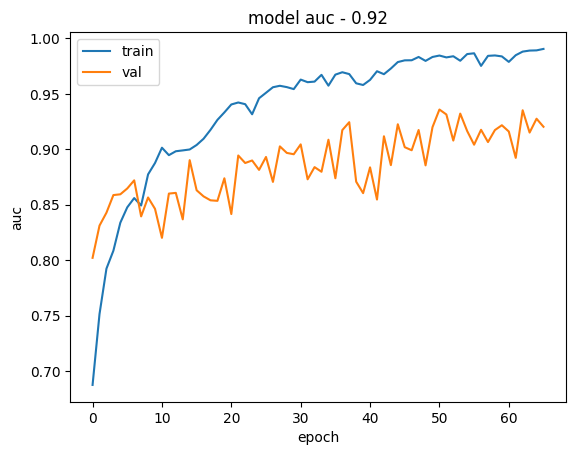

In [32]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(result[1], "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Precision
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('model precision - ' + str(format(result[3], "0.2f")))
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Recall
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('model recall - ' + str(format(result[4], "0.2f")))
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# AUC
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model auc - ' + str(format(result[2], "0.2f")))
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### CONFUSION MATRIX

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


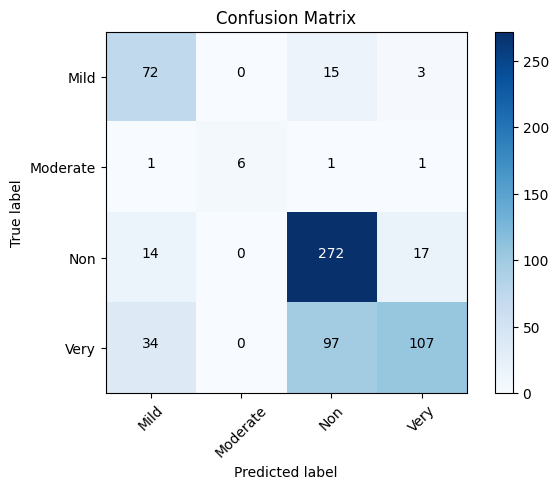

In [33]:
from itertools import product
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = alzheimer_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
correct_labels = np.argmax(correct_labels,axis=1)
confusion_mtx = confusion_matrix(correct_labels, predicted_labels)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'Very']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
correct_labels.shape

(640,)

In [35]:
predicted_labels.shape

TensorShape([640])

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_single_image(model, img_path, class_names, img_size=(128, 128)):
    """
    Predicts the class of a single image.

    Parameters:
        model (tf.keras.Model): The trained Alzheimer classifier model.
        img_path (str): Path to the image file.
        class_names (list): List of class names corresponding to model's outputs.
        img_size (tuple): Size to which the image will be resized.

    Returns:
        str: Predicted class name.
        np.ndarray: Probabilities of each class.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = applications.efficientnet.preprocess_input(img_array)  # Preprocess for EfficientNetB0

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get index of the highest probability
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name, predictions

# Test the function
test_image_path ='./Alzheimer_MRI_4_classes_dataset/VeryMildDemented/1 (13).jpg'
predicted_class, class_probabilities = predict_single_image(
    model=alzheimer_model,
    img_path=test_image_path,
    class_names=class_names
)

print(f"Predicted Class: {predicted_class}")
print(f"Class Probabilities: {class_probabilities}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Very
Class Probabilities: [[5.9439233e-05 9.2534676e-05 1.2191389e-02 9.8765659e-01]]
